In [1]:
import sys
import os
# Add the parent directory of `notebook/` to sys.path
sys.path.append(os.path.abspath(".."))

import torch
palette = ['#43AA8B', '#F8961E', '#F94144']
sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# data pre-processing and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d


# utilities
from utils.utils_data import (load_data, format_chemical_formula)
from e3nn.io import CartesianTensor

bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

# Create a colormap based on the number of unique symbols
datasets = ['g', 'y', 'r']
colors = dict(zip(datasets, palette))
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', [palette[k] for k in [0,2,1]])
mpl.rcParams['font.family'] = 'Arial'
font_size = 20  # or whatever size you want globally

mpl.rcParams.update({
    "font.size": font_size,           # Universal font size
    "axes.titlesize": font_size,       # Axes title
    "axes.labelsize": font_size,       # Axes labels
    "xtick.labelsize": font_size - 2,  # X tick labels
    "ytick.labelsize": font_size - 2,  # Y tick labels
    "legend.fontsize": font_size - 2,  # Legend text
    "figure.titlesize": font_size + 2, # Figure title
    "font.family": "Arial"             # Optional: use Arial everywhere
})

# Check device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print('torch device:' , device)

## load data
data_file = '../dataset/symmetrized_dataset.pkl'
df, species = load_data(data_file)
df = df.reset_index(drop=True)

print('data acquired')

energy_min = 0 #Unit of energy in eV
energy_max = 30 #Unit of energy in eV
nstep = 300 #Number of the energy points

new_x = np.linspace(energy_min, energy_max, nstep)
def interpolate_matrix(row, column):
    """Interpolates the full (3001, 3, 3) matrix along the energy axis."""
    matrix = row[column]  # Shape: (3001, 3, 3)
    omega = row['omega']  # Shape: (3001,)

    # Define interpolation along the first axis (energy axis)
    interp = interp1d(omega, matrix, kind='linear', axis=0, fill_value=0, bounds_error=False)

    # Apply interpolation to the new energy points
    new_matrix = interp(new_x)  # Result shape: (301, 3, 3)
    
    return new_matrix


# Apply the custom function to create a new column
df['energies_interp'] = df.apply(lambda x: new_x, axis=1)
df['real_Permittivity_Matrices_interp'] = df.apply(lambda row: interpolate_matrix(row, 'real_symmetrized_susceptibility'), axis=1)
df['imag_Permittivity_Matrices_interp'] = df.apply(lambda row: interpolate_matrix(row, 'imag_symmetrized_susceptibility'), axis=1)

df.sample(10)

torch device: cuda:0
data acquired


,formula,symmetrized_structure,mp_id,bandgap,crystal_system,omega,species,real_symmetrized_susceptibility,imag_symmetrized_susceptibility,rel_permittivity_real,rel_permittivity_imag,energies_interp,real_Permittivity_Matrices_interp,imag_Permittivity_Matrices_interp
1001,F4Hg4,"(Atom('Hg', [1.8295, 1.8295, 4.247215659999999...",mp-706,1.7704,tetragonal,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[Hg, F]","[[[1.7456238490929041, 0.0, 4.8467614016778965...","[[[4.9936673730763945e-18, 0.0, 0.0], [0.0, 4....","[[[2.745623849092904, 0.0, 4.8467614016778965e...","[[[4.9936673730763945e-18, 0.0, 0.0], [0.0, 4....","[0.0, 0.10033444816053512, 0.20066889632107024...","[[[1.7456238490929041, 0.0, 4.8467614016778965...","[[[4.9936673730763945e-18, 0.0, 0.0], [0.0, 4...."
131,C8Ca4,"(Atom('Ca', [-1.6484900375464921, 3.4361430479...",mp-1575,2.0383,monoclinic,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[Ca, C]","[[[1.4440923170801627, 0.0, 0.0791659413005031...","[[[-2.932856084065435e-18, 0.0, 8.779543617695...","[[[2.4440923170801625, 0.0, 0.0791659413005031...","[[[-2.932856084065435e-18, 0.0, 8.779543617695...","[0.0, 0.10033444816053512, 0.20066889632107024...","[[[1.4440923170801627, 0.0, 0.0791659413005031...","[[[-2.932856084065435e-18, 0.0, 8.779543617695..."
1231,Cl4PdTl2,"(Atom('Tl', [3.58335, 0.0, 2.1033], index=0), ...",mp-29889,1.0534,tetragonal,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[Tl, Cl, Pd]","[[[1.8750688876180708, 0.0, 0.0], [0.0, 1.8750...","[[[-2.2139185946078473e-18, 0.0, 1.20370621524...","[[[2.875068887618071, 0.0, 0.0], [0.0, 2.87506...","[[[-2.2139185946078473e-18, 0.0, 1.20370621524...","[0.0, 0.10033444816053512, 0.20066889632107024...","[[[1.8750688876180708, 0.0, 0.0], [0.0, 1.8750...","[[[-2.2139185946078473e-18, 0.0, 1.20370621524..."
66,Br12Cs4Pb4,"(Atom('Cs', [0.0, 4.09905, 3.02145], index=0),...",mp-1014168,1.8178,tetragonal,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[Br, Cs, Pb]","[[[1.9087344824328918, 0.0, 0.0], [0.0, 1.9087...","[[[-1.8317706445159863e-18, 0.0, 4.81482486096...","[[[2.908734482432892, 0.0, 0.0], [0.0, 2.90873...","[[[-1.8317706445159863e-18, 0.0, 4.81482486096...","[0.0, 0.10033444816053512, 0.20066889632107024...","[[[1.9087344824328918, 0.0, 0.0], [0.0, 1.9087...","[[[-1.8317706445159863e-18, 0.0, 4.81482486096..."
1034,Al4As4,"(Atom('Al', [0.0, 0.0, 0.0], index=0), Atom('A...",mp-2172,1.5037,cubic,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[Al, As]","[[[4.209944234671533, -2.1541161785235095e-27,...","[[[-4.381150847383134e-18, 0.0, 0.0], [0.0, -4...","[[[5.209944234671533, -2.1541161785235095e-27,...","[[[-4.381150847383134e-18, 0.0, 0.0], [0.0, -4...","[0.0, 0.10033444816053512, 0.20066889632107024...","[[[4.209944234671533, -2.1541161785235095e-27,...","[[[-4.381150847383134e-18, 0.0, 0.0], [0.0, -4..."
1228,Ag4K4O8,"(Atom('K', [0.0, 8.598092942000001, 4.444875],...",mp-997088,0.9659,orthorhombic,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[Ag, K, O]","[[[0.8269158763284654, -2.0679515313825692e-25...","[[[-1.137234988578552e-18, 9.62964972193618e-3...","[[[1.8269158763284654, -2.0679515313825692e-25...","[[[-1.137234988578552e-18, 9.62964972193618e-3...","[0.0, 0.10033444816053512, 0.20066889632107024...","[[[0.8269158763284654, -2.0679515313825692e-25...","[[[-1.137234988578552e-18, 9.62964972193618e-3..."
664,Ga8S12,"(Atom('Ga', [1.954397487849071, 3.655773415999...",mp-539,1.7106,monoclinic,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[Ga, S]","[[[2.7548365364761733, 0.0, 0.0530551638142288...","[[[-3.451134124868112e-18, 0.0, -2.85606189162...","[[[3.7548365364761733, 0.0, 0.0530551638142288...","[[[-3.451134124868112e-18, 0.0, -2.85606189162...","[0.0, 0.10033444816053512, 0.20066889632107024...","[[[2.7548365364761733, 0.0, 0.0530551638142288...","[[[-3.451134124868112e-18, 0.0, -2.85606189162..."
670,Cs12Sb4,"(Atom('Cs', [2.3113999999999995, 2.31139999999...",mp-10378,0.6126,cubic,"[0.0, 0.01, 0.02, 0

In [ ]:
df["real_Permittivity_Matrices_interp"].iloc[0].shape

(300, 3, 3)

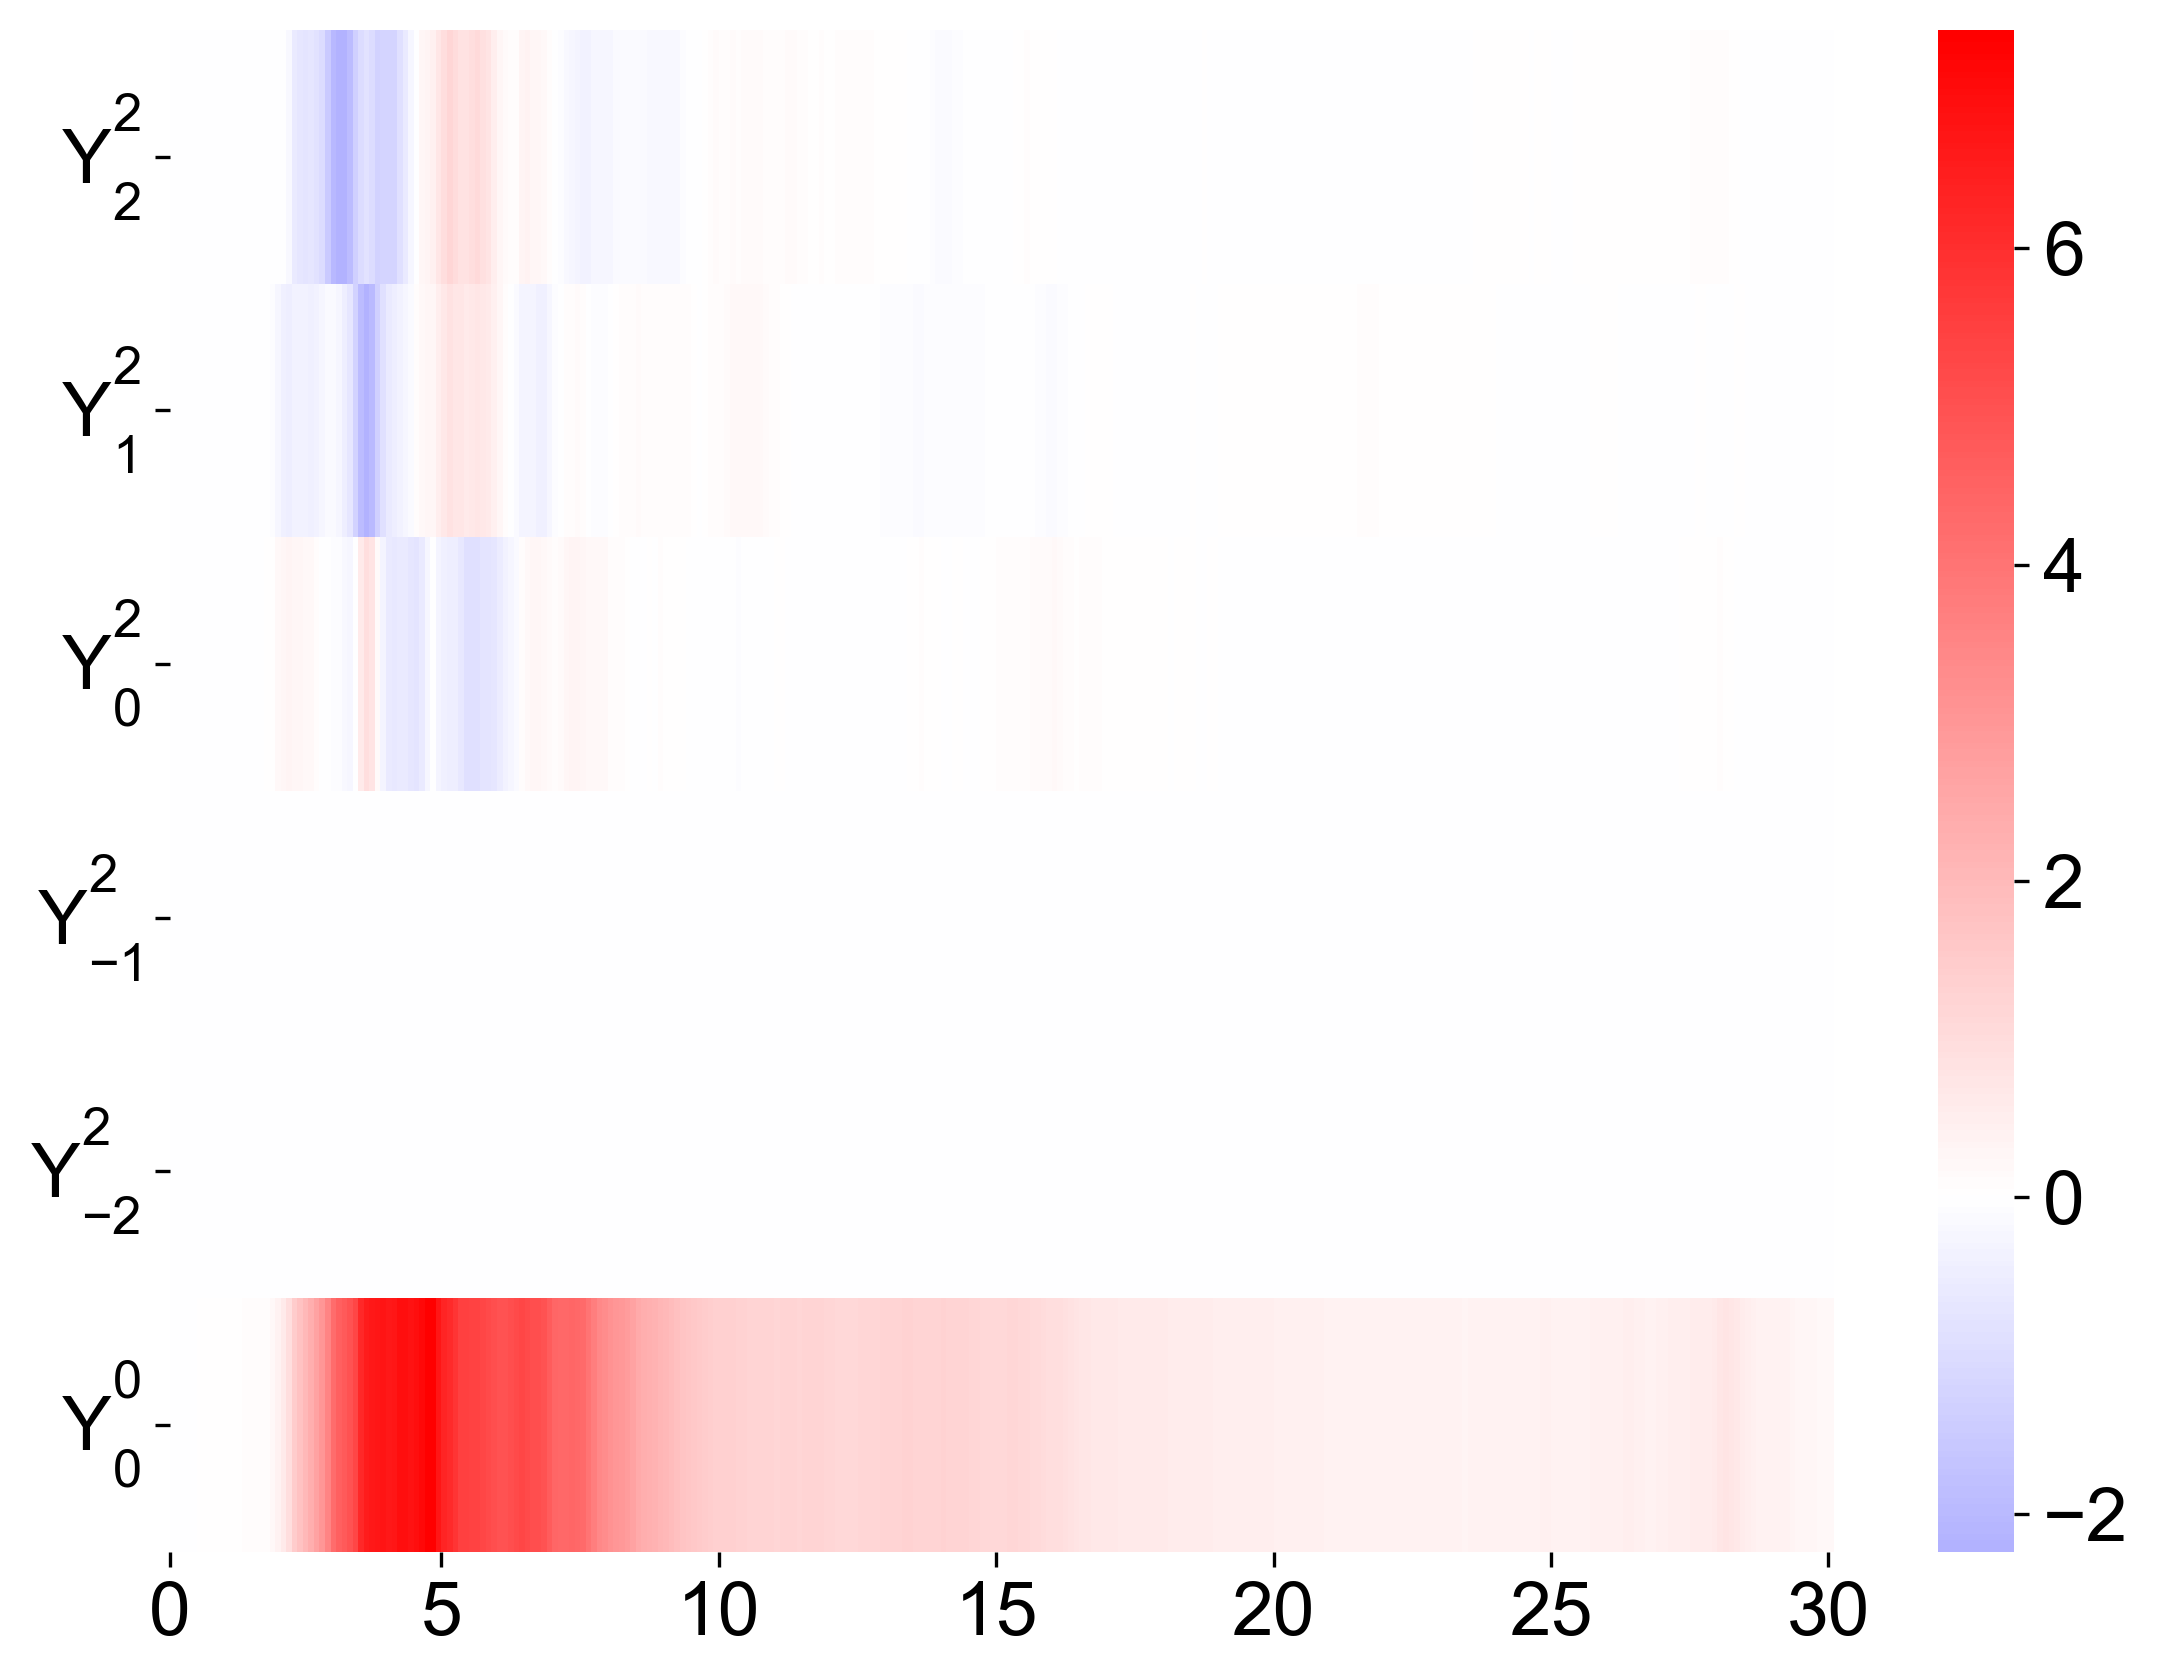

In [3]:
# Set default dtype globally
torch.set_default_dtype(torch.float64)

N_samples = 1
# sampled_df = df.sample(n=N_samples)  # Fix seed for reproducibility
selected_df = df[df["mp_id"] == "mp-996969"] # monoclinic
# selected_df = df[df["mp_id"] == "mp-766"] # orthorhombic
# selected_df = df[df["mp_id"] == "mp-29678"] # trigonal
# selected_df = df[df["mp_id"] == "mp-441"] # cubic
# selected_df = df[df["mp_id"] == "mp-10616"] # tetragonal
# selected_df = df[df["mp_id"] == "mp-10616"] # hexagonal
# selected_df = df[df["mp_id"] == "mp-2422143"] # triclinic
# selected_df = df[df["mp_id"] == "mp-1077942"] # 


# Load the dataset
permittivity = torch.tensor(selected_df["imag_Permittivity_Matrices_interp"].iloc[0], dtype=torch.float64)  # Shape (301, 3, 3)
omega = selected_df["energies_interp"].iloc[0]  # Shape (301,)
perm = torch.tensor([1, 2, 0])  # Permutation: x->2, y->0, z->1

# Permute both row and column indices in one line
permittivity_perm = permittivity.index_select(1, perm).index_select(2, perm)

# Transform Cartesian tensor to irreps
x = CartesianTensor("ij=ji")  # Symmetric rank-2 tensor
X_irrep = x.from_cartesian(permittivity_perm)  # Converts (301, 3, 3) -> (301, 6)

# **Transpose the data** so that omega is on the x-axis
X_irrep_transposed = X_irrep.T.numpy()  # Now shape (6, 301)

# Define component labels (REVERSED to put Y^0_0 at the bottom)
component_ticks = [r"$Y^2_2$", r"$Y^2_{1}$", r"$Y^2_0$", r"$Y^2_{-1}$", r"$Y^2_{-2}$", r"$Y^0_0$"]
# component_ticks = [r"", r"", r"", r"", r"", r""]

X_irrep_transposed = X_irrep_transposed[::-1, :]

plt.figure(figsize=(8,6), dpi=300)
ax = sns.heatmap(
    X_irrep_transposed, 
    cmap='bwr', 
    center=0, 
    yticklabels=component_ticks, 
    xticklabels=50,
    linecolor='white',
    linewidths=0,
    cbar=True  
)

# Remove the axis frames (spines)
for spine in ax.spines.values():
    spine.set_visible(False)

# Set custom x-ticks
num_omega = len(omega)
tick_indices = np.linspace(0, num_omega - 1, 7, dtype=int)
tick_labels = [int(round(omega[idx])) for idx in tick_indices]

ax.set_xticks(tick_indices)
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(component_ticks, rotation=0, va="center")

plt.tight_layout()
plt.show()


AsBaLi, hexagonal


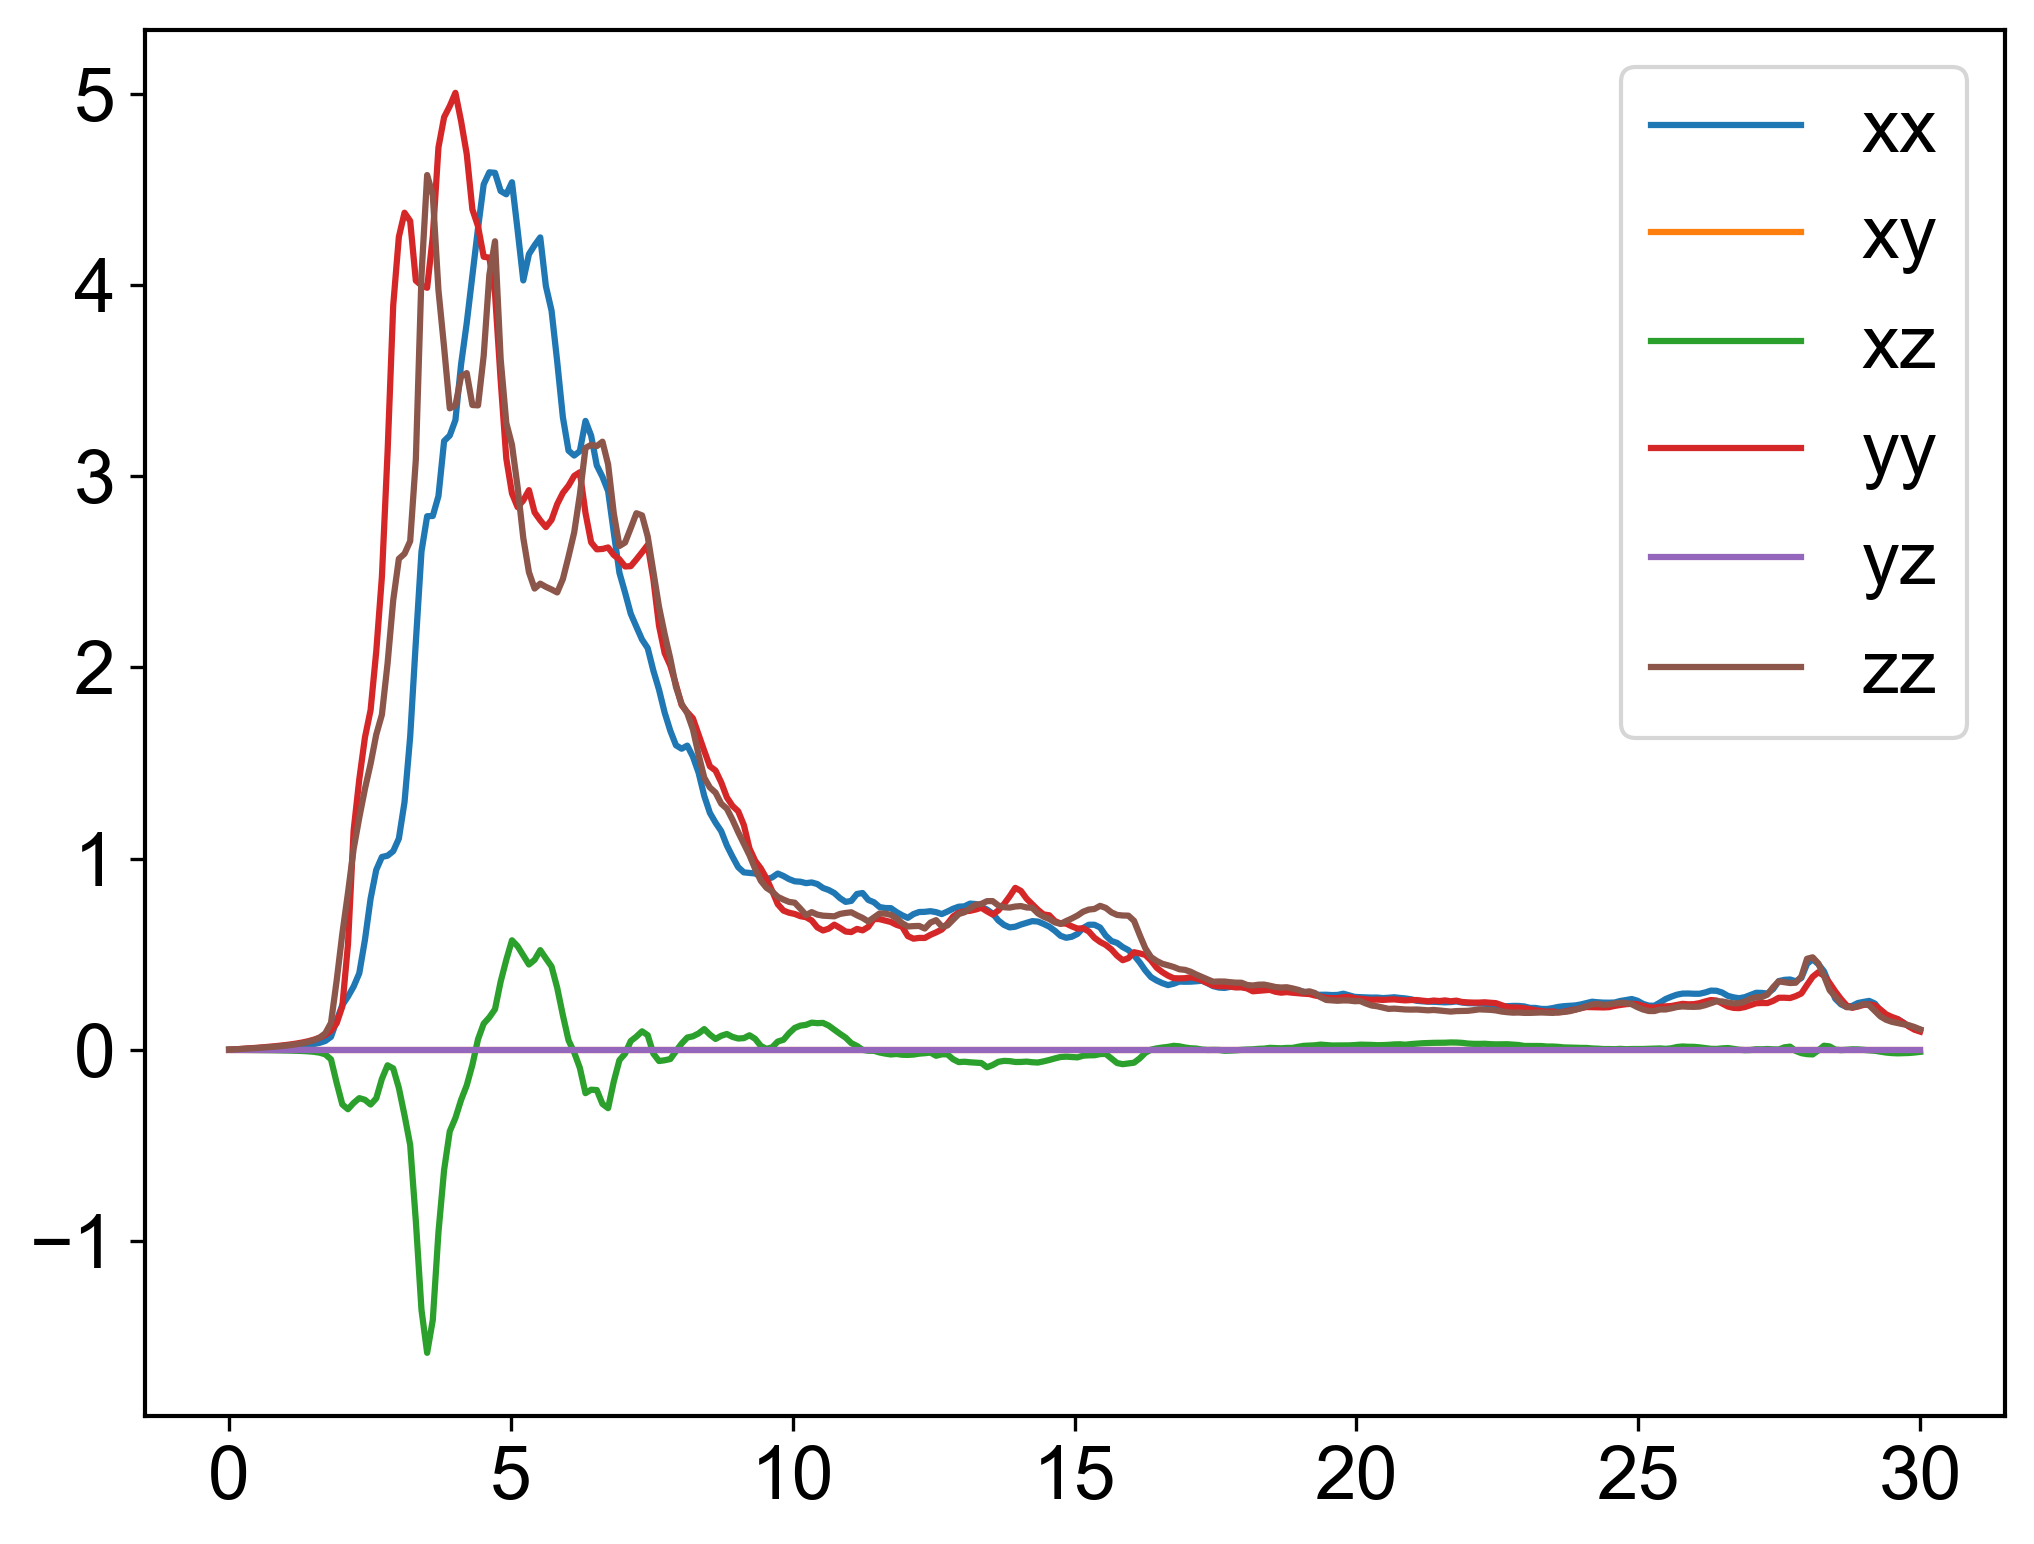

In [4]:
test_transforamtion = x.to_cartesian(X_irrep)
inv_perm = torch.tensor([2, 0, 1])

# Permute back the row indices (dimension 1)
test_transforamtion_restored = test_transforamtion.index_select(1, inv_perm)
# Permute back the column indices (dimension 2)
test_transforamtion_restored = test_transforamtion_restored.index_select(2, inv_perm)

xyz_list = ['x', 'y', 'z']
color_map = {
    'xx': '#1f77b4',  # Blue
    'xy': '#ff7f0e',  # Orange
    'xz': '#2ca02c',  # Green
    'yy': '#d62728',  # Red
    'yz': '#9467bd',  # Purple
    'zz': '#8c564b'   # Brown
}
plt.figure(figsize=(8, 6),dpi=300)  # Set figure size for clarity

for i in range(3):
    for j in range(i, 3):
        component = f"{xyz_list[i]}{xyz_list[j]}"
        plt.plot(omega, test_transforamtion_restored[:, i, j], label=rf"${{{xyz_list[i]}{xyz_list[j]}}}$", color=color_map[component])
        
        
selected_df = df[df["mp_id"] == "mp-10616"].iloc[0] # 
    
print(f"{selected_df.formula}, {selected_df.crystal_system}")
plt.legend()
plt.show()


AttributeError: 'Series' object has no attribute 'imag_symmetrized_permittivity'

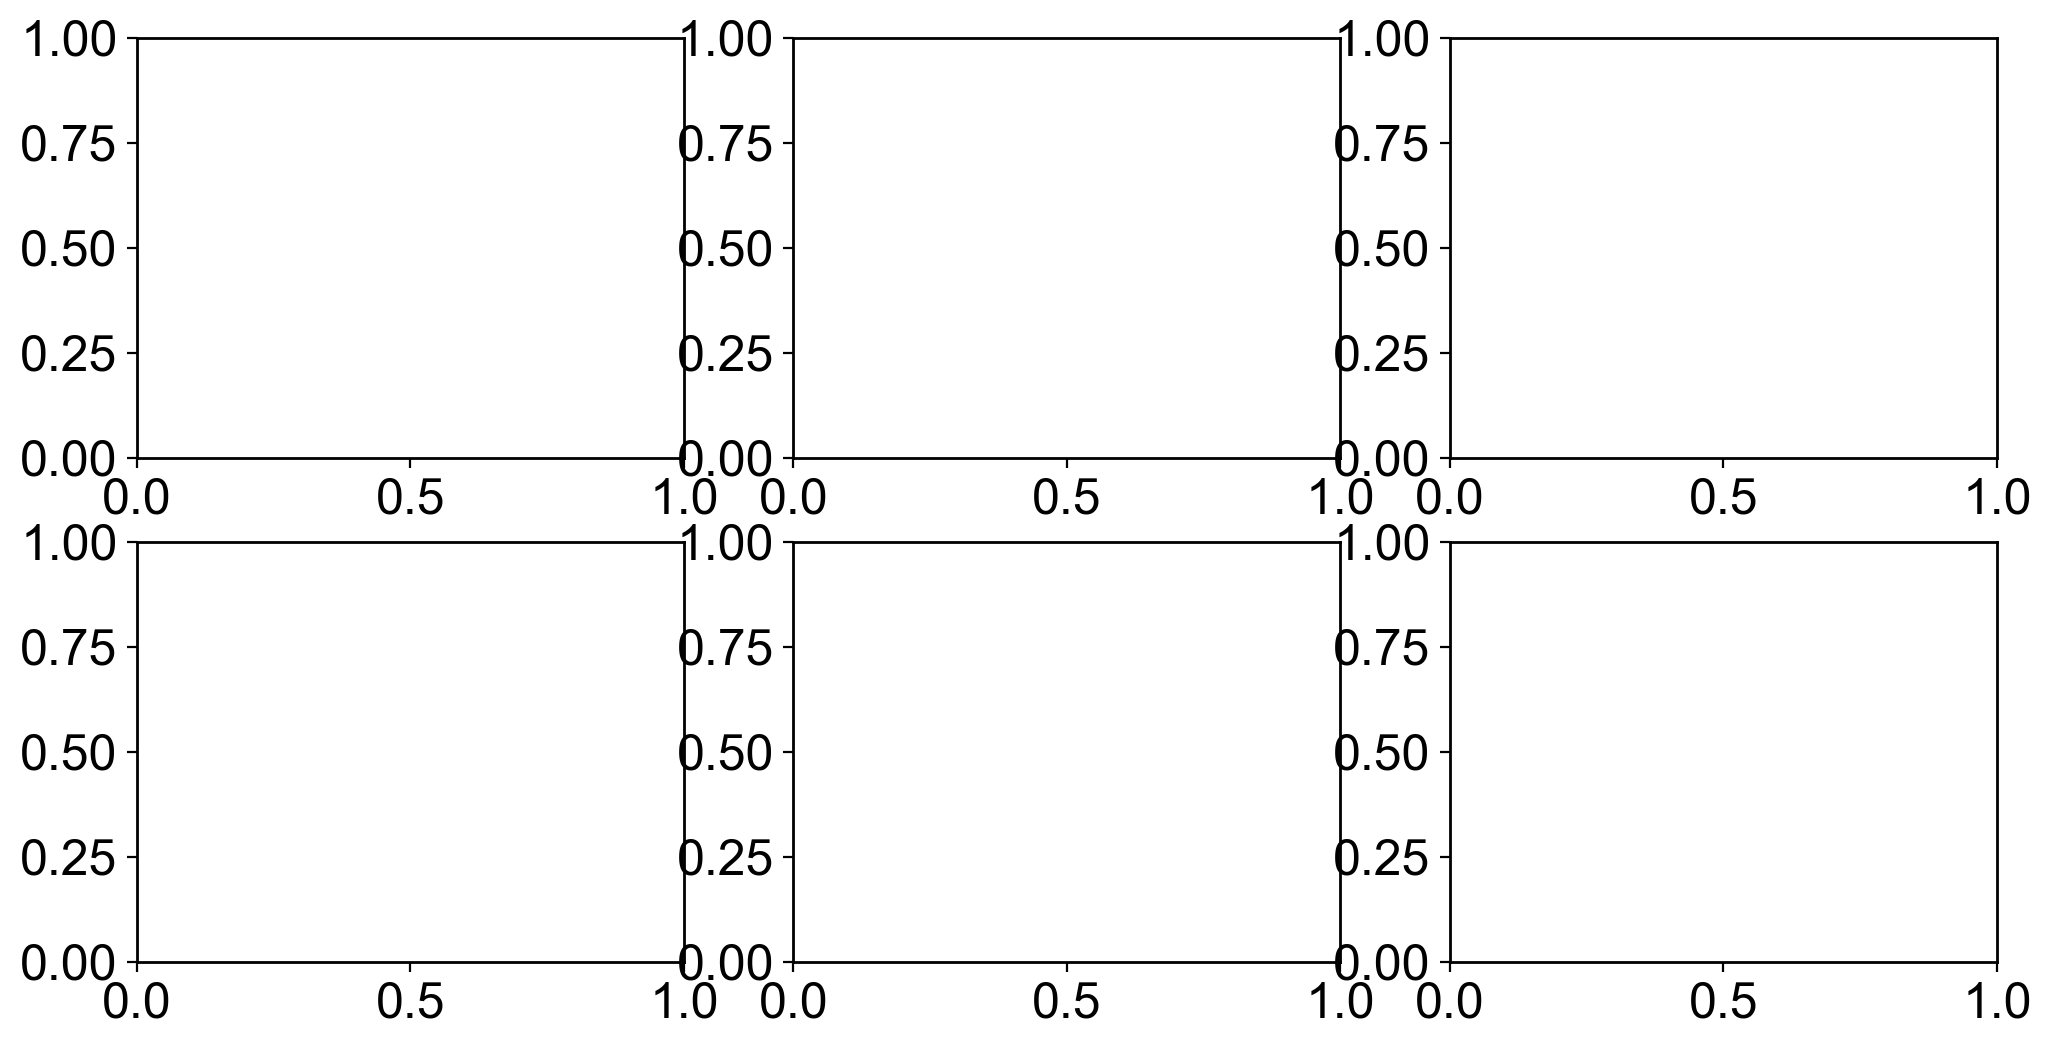

In [5]:
from matplotlib.ticker import MaxNLocator

selected_df = df[df["mp_id"] == "mp-9922"].iloc[0]
omega_interp = selected_df["energies_interp"]
omega = selected_df["omega"]
formula = selected_df["formula"]

crystal_system = selected_df["crystal_system"]

# Labels and component order
xyz_list = ['x', 'y', 'z']
components = [(i, j) for i in range(3) for j in range(i, 3)]  # xx, xy, xz, yy, yz, zz
fig, axes = plt.subplots(2, 3, figsize=(12, 6), dpi=200)  # Wider and a bit taller
axes = axes.ravel()

for k, (i, j) in enumerate(components):
    ax = axes[k]
    component = f"{xyz_list[i]}{xyz_list[j]}"
    
    ax.plot(omega, selected_df.imag_symmetrized_permittivity[:, i, j], label="Original", color="black")
    ax.scatter(omega_interp, selected_df.imag_Permittivity_Matrices_interp[:, i, j], label="Interpolated", color="red", s=10)
    
    ax.set_title(rf"$\chi_{{{component}}}$")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=4))

# Shared legend below all subplots
handles, labels = axes[0].get_legend_handles_labels()
# Add legend slightly above the bottom
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, -0.02), ncol=2, frameon=False)

# Global labels and title
formatted_formula = format_chemical_formula(formula)
fig.suptitle(rf"${formatted_formula}$, {crystal_system}", y=1.0)
fig.supylabel(r"Im $\chi_{{ij}}(\omega)$ (F/m)", x=0.02)
fig.supxlabel(r"Photon frequency (eV)", y=-0.05)  # Lowered further
plt.subplots_adjust(left=0.08, right=0.98, top=0.88, bottom=0.12, wspace=0.35, hspace=0.4)
plt.show()


In [6]:
## load data
data_file = '../dataset/symmetrized_dataset.pkl'
df, species = load_data(data_file)
df = df.reset_index(drop=True)

print('data acquired')



energy_min = 0 #Unit of energy in eV
energy_max = 30 #Unit of energy in eV
nstep = 300 #Number of the energy points

new_x = np.linspace(energy_min, energy_max, nstep)
# Efficiently interpolate all matrices using list comprehension
def interpolate_matrix(matrix, omega):
    """Interpolates the full (3001, 3, 3) matrix along the energy axis."""
    interp = interp1d(omega, matrix, kind='linear', axis=0, fill_value=0, bounds_error=False)
    return interp(new_x)  # Shape: (300, 3, 3)


# Apply interpolation efficiently
df['real_Permittivity_Matrices_interp'] = [
    interpolate_matrix(row['real_symmetrized_permittivity'], row['omega']) for _, row in df.iterrows()
]

# Apply the custom function to create a new column
df['energies_interp'] = df.apply(lambda x: new_x, axis=1)

perm_matrices_tensor = torch.tensor(np.stack(df['real_Permittivity_Matrices_interp'].values), dtype=torch.float64, device=device)


# Transform Cartesian tensor to irreps
x = CartesianTensor("ij=ji")  # Symmetric rank-2 tensor
sph_coefs_tensor = x.from_cartesian(perm_matrices_tensor)  # Shape: (num_samples, 201, 6)

df['sph_coefs'] = list(sph_coefs_tensor.cpu().numpy())  # Move to CPU and store as list

data acquired


KeyError: 'real_symmetrized_permittivity'

In [ ]:
df.head()

,formula,symmetrized_structure,mp_id,bandgap,crystal_system,omega,species,real_symmetrized_permittivity,imag_symmetrized_permittivity,real_Permittivity_Matrices_interp,energies_interp,sph_coefs
0,Li4Se8Y4,"(Atom('Li', [2.8385500000000006, 0.0, 2.88335]...",mp-37879,1.6604,tetragonal,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[Li, Se, Y]","[[[3.4812758467294405, 0.0, -2.584939414228211...","[[[-1.2523566768095863e-17, 0.0, -4.8148248609...","[[[3.4812758467294405, 0.0, -2.584939414228211...","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[[5.959240426000634, -3.6556563775142996e-26, ..."
1,Mo3S2Se4,"(Atom('Mo', [1.6365999999999998, 0.94489145055...",mp-1025906,0.5619,trigonal,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[S, Se, Mo]","[[[5.124538605076387, 6.794333614242494e-18, 5...","[[[2.6245939830145304e-17, -2.5679065925163146...","[[[5.124538605076387, 6.794333614242494e-18, 5...","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[[7.484942414828355, 9.233700588750786e-22, -2..."
2,Li3NbS4,"(Atom('Li', [0.0, 0.0, 3.0251], index=0), Atom...",mp-755309,2.8348,cubic,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[Li, S, Nb]","[[[1.7313150452437125, -3.529303946892918e-23,...","[[[9.73175816465002e-19, 0.0, 0.0], [0.0, 9.73...","[[[1.7313150452437125, -3.529303946892918e-23,...","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[[2.99872562227052, -4.991189507432857e-23, -4..."
3,CdSe2Zn,"(Atom('Zn', [2.07525, 2.07525, 2.981], index=0...",mp-1017534,0.7236,tetragonal,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[Se, Zn, Cd]","[[[3.2667200732203123, 0.0, 0.0], [0.0, 3.2667...","[[[-8.841535879698145e-18, 0.0, -9.62964972193...","[[[3.2667200732203123, 0.0, 0.0], [0.0, 3.2667...","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[[5.665019662118925, 0.0, 0.0, -0.004875162690..."
4,Al8Te12,"(Atom('Al', [-1.0110162555088607, 0.7063003620...",mp-1228524,1.3222,monoclinic,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[Al, Te]","[[[3.57865600493003, 0.0, 0.0588499476841695],...","[[[-2.370171074423322e-18, 0.0, 3.360404376639...","[[[3.57865600493003, 0.0, 0.0588499476841695],...","[0.0, 0.1, 0.2, 0.30000000000000004, 0.4, 0.5,...","[[6.374499510179084, 0.0832263941598996, 0.0, ..."


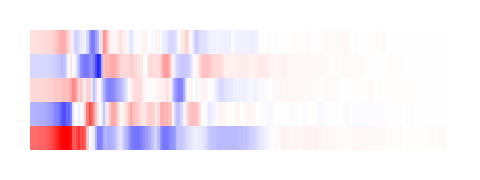

In [ ]:
selected_df = df[df["mp_id"] == "mp-2422143"]  # Example material

re_permittivity = torch.tensor(selected_df["real_Permittivity_Matrices_interp"].iloc[0], dtype=torch.float64)  
omega = selected_df["energies_interp"].iloc[0]  

# Transform Cartesian tensor to irreps
x = CartesianTensor("ij=ji")  # Symmetric rank-2 tensor
X_irrep = x.from_cartesian(re_permittivity)  # Converts (301, 3, 3) -> (251, 6)

# Extract l=2 components only (skip l=0)
X_l2 = X_irrep[:, 1:]  # Shape: (251, 5)

# Transpose the data so that omega is on the x-axis
X_irrep_transposed = X_l2.T.numpy()  
plt.figure(figsize=(2, 1), dpi=300)  
ax = sns.heatmap(X_irrep_transposed, cmap='bwr', center=0, yticklabels=False, xticklabels=False, cbar=False)
plt.tight_layout()
plt.show()

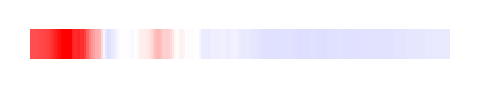

In [ ]:
# **Extract l=0 channel only**
X_l0 = X_irrep[:, 0]

# **Reshape for heatmap** 
X_l0_transposed = X_l0[None, :].numpy() 

# Plot the tiny heatmap without a colorbar
plt.figure(figsize=(2, 0.7), dpi=300)  # Smaller height since it's 1 row

ax = sns.heatmap(X_l0_transposed, cmap='bwr', center=0, yticklabels=False, xticklabels=False, cbar=False)
plt.tight_layout()
plt.show()